# BME-1312 Lab-1: Construct your CNN for MRI reconstruction


In [ ]:
######################## WRITE YOUR ANSWER BELOW ########################
STUDENT_NAME = "Example"
STUDENT_NUMBER = "1234567890"
#########################################################################

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup environments

You are required to install the following packages.

- jupyter
- scikit-image
- numPy
- pytorch torchvision
- matplotlib
- tqdm


In [45]:
# necessary packages for this homework, you are free to import more.
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import functional as F
from torchvision import transforms

# packages of this lab
from bme1312 import lab1 as lab

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Part 1: Understand MRI data

### Part 1A: Data loading

Here a subset of fastMRI single coil dataset is provided. There are 1000 complex-valued images for you to perform MRI reconstruction. We already preprocessed the dataset by center croped (256x256) and normalization.

Here are some examples:
![dataset](./assets/selected_1000_illustration.png)


In [ ]:
knee_dataset = lab.FastmriKnee(path="./data/knee_singlecoil_1000.npz")

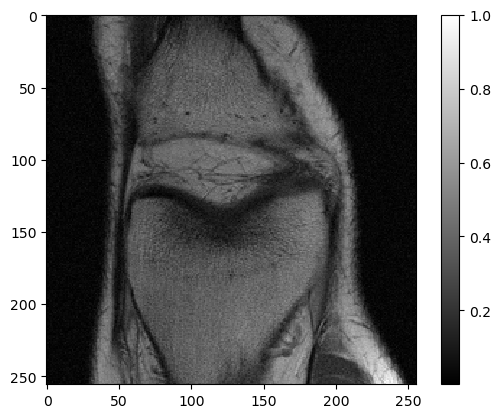

In [ ]:
# helper function: Visualize a sample
def visualize_data_point(data_point):
    im_gt = data_point
    img = lab.pseudo2real(im_gt)
    lab.imgshow(img)


# Try different index range in [0, 1000) to see different images in dataset.
index = 270
visualize_data_point(knee_dataset[index])

### Part 1B: MRI cartesian undersample

In order to acclerate MRI acquisition, it is common to perform undersample accleration. Here we simulate cartesian undersampling strategy. We implemented undersampling functionality in dataset object. The return values of our dataset is:

1. The undersampled kspace.
2. Undersampling pattern.
3. Fully sampled image.


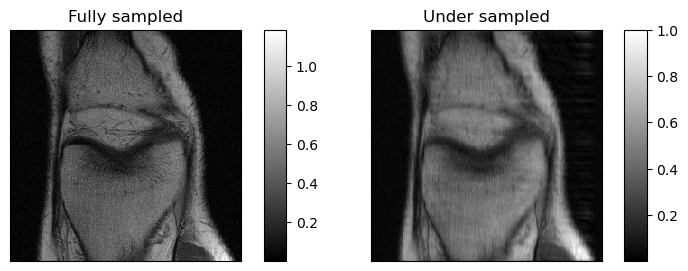

In [ ]:
dataset = lab.DatasetReconMRI(dataset=knee_dataset)


def helper_show_data_point(data_point):
    k_und, und_mask, im_gt = data_point
    img_und = np.abs(lab.kspace2image(lab.pseudo2complex(k_und)))
    img_gt = lab.pseudo2real(im_gt)
    lab.imsshow(
        [img_gt, img_und], titles=["Fully sampled", "Under sampled"], is_colorbar=True
    )


# Try different index range in [0, 1000) to see different images in dataset.
index = 270
helper_show_data_point(dataset[index])

**Task of acclerated MRI reconstruction**: reconstruct undersampled kspace (corresponding to _under sampled_) data into images as close to fully sampled as possible. Describle what you have observed in the comparision.

$\large \color{#a30b19}{Answer:}$


### Part 1C: Prepare dataset loaders

Three data loaders will be used in the following training, validation and testing phases. Most of codes are provided, you need to understand the usage of `torch.utils.data.DataLoader` and build `val_loader` and `test_loader` by yourself.


In [ ]:
TRAIN_INDICES = np.arange(0, 600)
TEST_INDICES = np.arange(600, 800)
VAL_INDICES = np.arange(800, 1000)


def build_loaders(
    dataset,
    train_indices,
    val_indices,
    test_indices,
    batch_size=10,
    train_augment_fn=None,
    num_workers=4,
):
    train_subset, val_subset, test_subset = lab.split_dataset(
        dataset=dataset, indices_list=[train_indices, val_indices, test_indices]
    )

    train_dataset = lab.DatasetReconMRI(train_subset, augment_fn=train_augment_fn)
    val_dataset = lab.DatasetReconMRI(val_subset)
    test_dataset = lab.DatasetReconMRI(test_subset)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers
    )
    ######################## WRITE YOUR ANSWER BELOW ########################
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, num_workers=num_workers
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, num_workers=num_workers
    )
    ########################################################################

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = build_loaders(
    knee_dataset,
    TRAIN_INDICES,
    VAL_INDICES,
    TEST_INDICES,
    batch_size=32,  # Reduce this number if your computer does not has large gpu vram
)
print(
    f"Number of batches for train/val/test: {len(train_loader)}/{len(val_loader)}/{len(test_loader)}"
)

Number of batches for train/val/test: 19/7/7


## Part 2: Build your CNN


### Part 2A: Base framework is prepared.

We will perform MRI reconstruion from undersampled raw data in kspace. A framework is already provided to process kspace MRI data into images space. Yo need to pass a CNN instance as the argument `recon_net` into the framework in order to make it usable.

The initial input `k_und` is a pseudo-complex\* kspace data, which is converted to pseudo-complex image by the following steps:

1. Convert `(2, H, W) pseudo-complex` data into `(H, W) complex`
2. Perform ifft on `(H, W) complex`, we transform the kspace into image space
3. Convert `(H, W) complex` image into `(2, H, W) pseudo-complex` image

\* pseudo-complex: a method for representing complex data in `float` data type. Two channels are used to represent real and imaginary part. Eg. a pseudo-complex image can be represented in the dimensions of `(2, H, W)`.

<center>
<img src="./assets/framework.png" width=600pt>
</center>


In [ ]:
class MRIReconstructionFramework(nn.Module):
    def __init__(self, recon_net: nn.Module):
        super().__init__()
        self.recon_net = recon_net

    def forward(self, k_und, mask):
        B, C, H, W = k_und.shape
        assert C == 2
        assert (B, H, W) == tuple(mask.shape)

        im_und = lab.complex2pseudo(lab.kspace2image(lab.pseudo2complex(k_und)))
        ######################## WRITE YOUR ANSWER BELOW ########################
        im_recon = self.recon_net(im_und)
        ########################################################################
        return im_recon

### Part 2B: Define a simple CNN

Use the knowledge you learned from this course to build a simple CNN. We already define necessary components for you, all you need is complete the `forward` function.

A schematic illustration of the network you need to implement:

<center>
<img src="./assets/5-layer-cnn.png" width=600pt>
</center>


In [ ]:
# Network definition
class MultiLayerCNN(nn.Module):
    def __init__(self, n_hidden=64):
        super().__init__()
        self.conv1 = nn.Conv2d(2, n_hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(n_hidden, 2, kernel_size=3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, im_und):
        """
        - im_und: tensor[B, C=2, H, W]
        """
        ######################## WRITE YOUR ANSWER BELOW ########################
        x = self.relu(self.conv1(im_und))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        diff = self.conv5(x)
        im_recon = diff + im_und
        #########################################################################
        return im_recon


# test a forward
im_mock = torch.randn(1, 2, 256, 256)
net = MultiLayerCNN()
out = net(im_mock)
print(out.shape)
assert (1, 2, 256, 256) == tuple(out.shape)

torch.Size([1, 2, 256, 256])


### Part 2C: Define your Loss function

Implement a Mean-Squared-Error function. $y$ is the fully-sampled MRI images, which is ground truth. $x$ is your CNN's reconstruciton. $N$ is the number of pixels in each image.

$$
L_\text{mse} = \frac{1}{N} \sum_{i=1}^N{\left \| y_i - x_i \right \|^2}, \quad i = 1, \cdots, N
$$


In [ ]:
class MSELoss:
    def __call__(self, im_recon, im_gt):
        """
        - im_recon: tensor[B, C=2, H, W]
        - im_gt: tensor[B, C=2, H, W]
        """
        B, C, H, W = im_recon.shape
        x = lab.pseudo2real(im_recon)  # [B, H, W]
        y = lab.pseudo2real(im_gt)  # [B, H, W]
        ######################## WRITE YOUR ANSWER BELOW ########################
        loss = torch.mean((y - x) ** 2) * B
        #########################################################################
        return loss


# test for loss computation
mse = MSELoss()
x_mock = torch.randn(1, 2, 256, 256)
y_mock = torch.randn(1, 2, 256, 256)
assert mse(x_mock, y_mock) >= 0

### Part 2D: Train SimpleReconCNN


In Lab0, you implemented a simple framework of PyTorch training and validation. To train a MRI reconstruction network, the framework is much more complicated. We want you to focus on the model and learn the basic intuitions of deep learning MRI reconstruction, thus the boilerplates are provide for you to perform training/validation/visualiztion interactivly, wraped in `lab.Solver` class.


  0%|          | 0/600 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

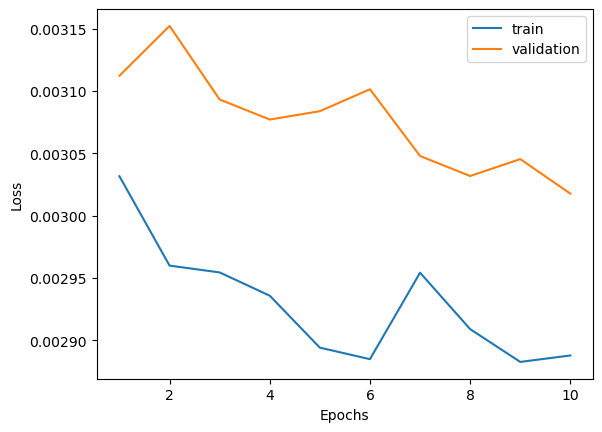

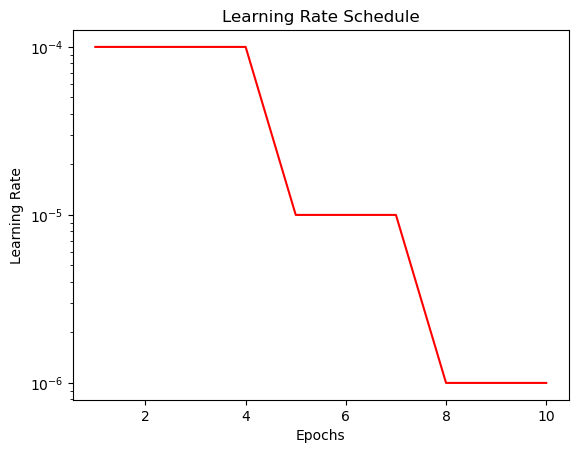

[Validation]:   0%|          | 0/200 [00:00<?, ?img/s]

============================== Measurements==============================
[avg_PSNR] 24.47992745399475
[avg_SSIM] 0.643781389497466


In [ ]:
# Define network
net = MRIReconstructionFramework(
    ######################## WRITE YOUR ANSWER BELOW ########################
    recon_net=MultiLayerCNN()
    #########################################################################
)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
# Training & Validation
solver = lab.Solver(
    model=net,
    optimizer=optimizer,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=2
    ),
    criterion=MSELoss(),
)

epochs_to_train = 10
solver.train(epochs_to_train, train_loader, val_loader=val_loader)
solver.validate(test_loader)

### Part 2E: Visualize


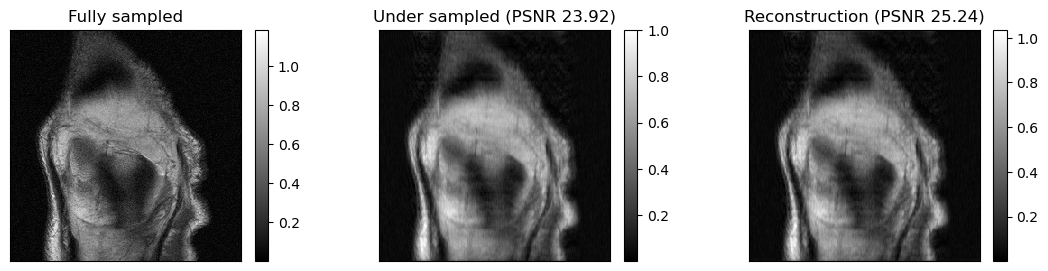

In [54]:
# changing data_index to see diffferent sample's visualization
data_index = 100  # range in [0, 200)
solver.visualize(test_loader, data_index, dpi=100)

Describle what you have observed in the comparision.

$\large \color{#a30b19}{Answer:}$


# Part 3: Techniques to make your CNN stronger


### Part 3A: Cascade Network

Cascade network is a method frequently used in MRI reconstruction. In this section you will change your network into a cascaded style. The cascade framework and its data consistency layer are already implemented, you need to embed your network into the framework by passing your network instance through argument `recon_net` and specify the number of cascades.

Schematic illustration of network architecture, adopted from:

> Schlemper, Jo, Jose Caballero, Joseph V. Hajnal, Anthony Price, and Daniel Rueckert. 2017. “A Deep Cascade of Convolutional Neural Networks for MR Image Reconstruction.” In International Conference on Information Processing in Medical Imaging, 647–58. Springer.

<center>
<img src="./assets/dccnn.png" width=600pt>
</center>


In [55]:
class CascadeMRIReconstructionFramework(nn.Module):
    def __init__(self, recon_net: nn.Module, n_cascade: int):
        super().__init__()
        self.recon_net = recon_net
        self.n_cascade = n_cascade

        assert n_cascade > 0
        dc_layers = [lab.DataConsistencyLayer() for _ in range(n_cascade)]
        self.dc_layers = nn.ModuleList(dc_layers)

    def forward(self, k_und, mask):
        B, C, H, W = k_und.shape
        assert C == 2
        assert (B, H, W) == tuple(mask.shape)

        im_und = lab.complex2pseudo(lab.kspace2image(lab.pseudo2complex(k_und)))
        im_recon = im_und
        for dc_layer in self.dc_layers:
            im_recon = self.recon_net(im_recon)
            im_recon = dc_layer(im_recon, k_und, mask)
        return im_recon

In [ ]:
# Define network
net = CascadeMRIReconstructionFramework(
    ######################## WRITE YOUR ANSWER BELOW ########################
    recon_net=MultiLayerCNN(),
    #########################################################################
    n_cascade=5,
)

# test a forward
im_mock = torch.randn(1, 2, 256, 256)
mask_mock = torch.randn(1, 256, 256)
out = net(im_mock, mask_mock)
print(out.shape)
assert (1, 2, 256, 256) == tuple(out.shape)

torch.Size([1, 2, 256, 256])


  0%|          | 0/600 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

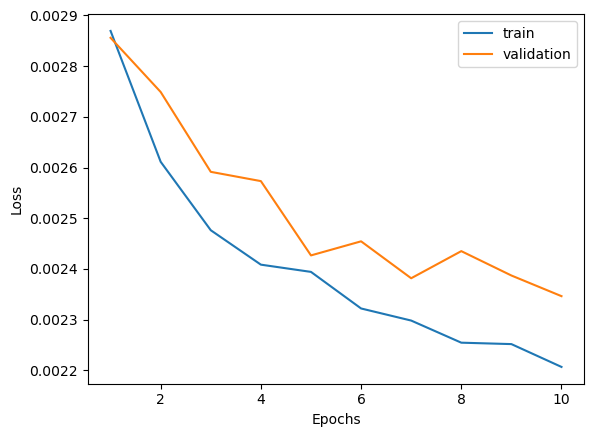

[Validation]:   0%|          | 0/200 [00:00<?, ?img/s]

============================== Measurements==============================
[avg_PSNR] 26.829253969192504
[avg_SSIM] 0.7037552039415338


In [ ]:
# Training & Validation
solver = lab.Solver(
    model=net,
    optimizer=torch.optim.Adam(net.parameters(), lr=0.0001),
    criterion=MSELoss(),
)

epochs_to_train = 10
solver.train(epochs_to_train, train_loader, val_loader=val_loader)
solver.validate(test_loader)

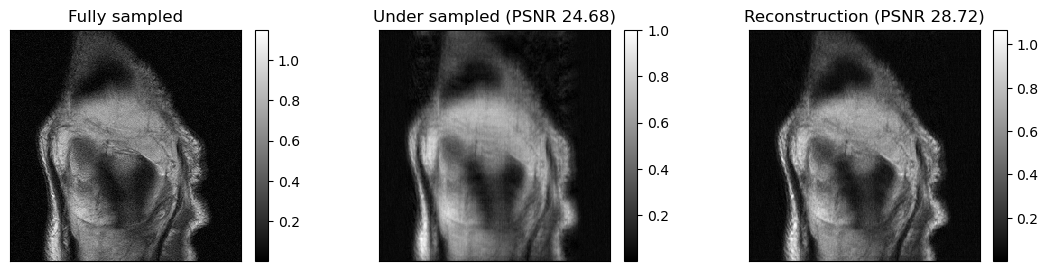

In [58]:
solver.visualize(test_loader, idx=100)

### Part 3B: Dropout.


Dropout is a commonly used techniques to reduce overfitting. We will modify the simple CNN by adding 2D Dropout layer into the network. Like `ReLU` in PyTorch, `Dropout2d` is a parameter-free layer, we can instantiate once and use it multiple times. You may find more detail about it in [PyTorch's document of Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html).

A schematic illustration of the network you need to implement.

<center>
<img src="./assets/5-layer-cnn-dropout.png" width=600pt>
</center>


In [59]:
# Network building
class CNN_Regularized(nn.Module):
    def __init__(self, n_hidden=64):
        super().__init__()
        ######################## WRITE YOUR ANSWER HERE ########################
        self.conv1 = nn.Conv2d(2, n_hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(n_hidden, 2, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        ########################################################################
        self.drop = nn.Dropout2d(p=0.1)

    def forward(self, im_und):
        """
        - im_und: tensor[B, C=2, H, W]
        """
        ######################## WRITE YOUR ANSWER HERE ########################
        x = self.drop(self.relu(self.conv1(im_und)))
        x = self.drop(self.relu(self.conv2(x)))
        x = self.drop(self.relu(self.conv3(x)))
        x = self.drop(self.relu(self.conv4(x)))
        diff = self.conv5(x)
        im_recon = diff + im_und
        ########################################################################
        return im_recon


# test a forward
im_mock = torch.randn(1, 2, 256, 256)
net = CNN_Regularized()
out = net(im_mock)
print(out.shape)
assert (1, 2, 256, 256) == tuple(out.shape)

torch.Size([1, 2, 256, 256])


### Part 3C: Data Augmentation


_Data augmentation_ is a method to overcome the scarcity of datasets. We can generate many augmented images from orgiginal dataset by modifying their intensities, locations or even shapes. In this section, you will learn how to implement data agumentation in PyTorch.


We leave a hook in the dataset class, which makes it possible for you to integrate a augmentation transform into the data generation process. You will implement a PyTorch transform object, and insert it into the dataset.

Two helper functions are given:

1. `torch.Tensor` is the primary type for PyTorch transforms and network's computation, while `np.ndarray` is the type inside our dataset, which is commonly used in the data preprocessing. That is why we need `compose_torch_augmentation` to manage the type casting between `np.ndarray` and `torch.Tensor`.
2. `helper_show_transform` will help you to visualize the augmented image and the original image.


In [ ]:
def compose_torch_augmentation(augmentations: list):
    augmentations.insert(0, transforms.Lambda(lambda x: torch.tensor(x)))
    augmentations.append(transforms.Lambda(lambda x: x.numpy()))
    return transforms.Compose(augmentations)


def helper_show_transform(data_point, transform):
    im_gt = data_point
    im_aug = transform(im_gt)
    im_gt = lab.pseudo2real(im_gt)
    im_aug = lab.pseudo2real(im_aug)
    lab.imsshow(
        [im_gt, im_aug], titles=["Fully sampled", "Transformed"], is_colorbar=True
    )

We implemented `affine_transform` for you as an example, you will implement the following transforms by yourself.

Hint: [Transforming and augmenting images — Torchvision 0.12 documentation](https://pytorch.org/vision/stable/transforms.html)


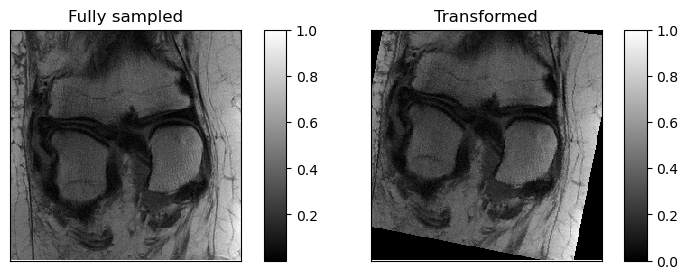

In [ ]:
affine_transform = transforms.RandomAffine(
    degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)
)
# Test
composed_transform = compose_torch_augmentation([affine_transform])

# Visualize
helper_show_transform(knee_dataset[100], composed_transform)

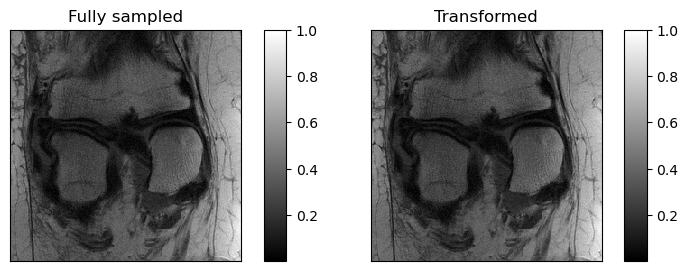

In [62]:
######################## WRITE YOUR ANSWER BELOW ########################
vertical_flip_transform = transforms.RandomVerticalFlip()
#########################################################################
composed_transform = compose_torch_augmentation([vertical_flip_transform])

# Visualize
helper_show_transform(knee_dataset[100], composed_transform)

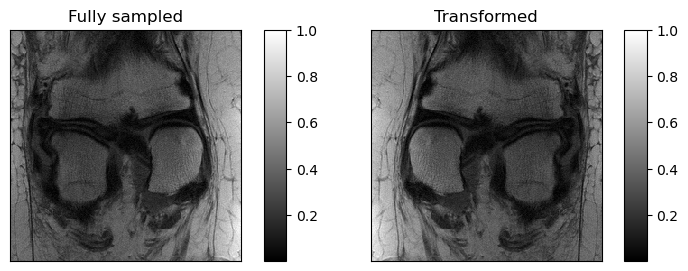

In [63]:
######################## WRITE YOUR ANSWER BELOW ########################
horizontal_flip_transform = transforms.RandomHorizontalFlip()
#########################################################################
composed_transform = compose_torch_augmentation([horizontal_flip_transform])

# Visualize
helper_show_transform(knee_dataset[100], composed_transform)

You may perform your own transform function beside the pre-define transformations in PyTorch. A wrapper named `transforms.Lambda()` can be used to handle this job.


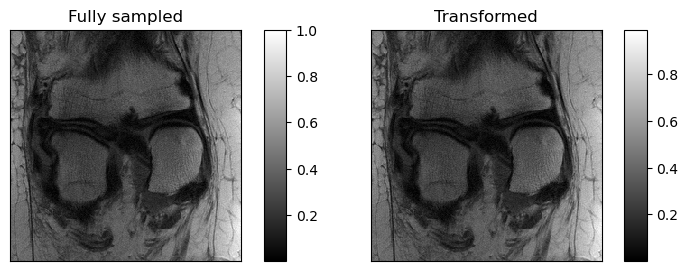

In [64]:
def intensity_variation(im):
    ratio = torch.clip(torch.randn(1), min=-3, max=3) * 0.1 + 1
    return im * ratio


######################## WRITE YOUR ANSWER BELOW ########################
# use `transforms.Lambda` to wrap `intensity_variation` function.
intensity_variation_transform = transforms.Lambda(lambda x: intensity_variation(x))
#########################################################################
composed_transform = compose_torch_augmentation([intensity_variation_transform])

# Visualize
helper_show_transform(knee_dataset[100], composed_transform)

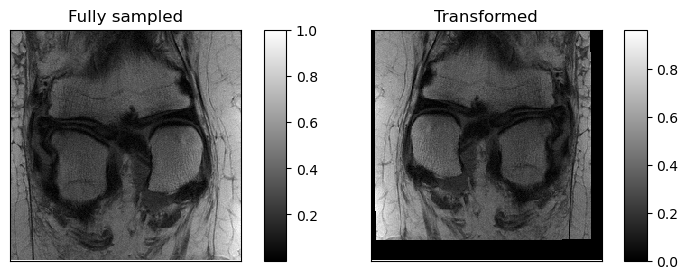

In [ ]:
aug_transform = compose_torch_augmentation(
    [
        affine_transform,
        vertical_flip_transform,
        horizontal_flip_transform,
        intensity_variation_transform,
    ]
)

# Visualize
helper_show_transform(knee_dataset[100], aug_transform)

Now, insert the composed transformations `aug_transform` into the data generation process. Simply pass it to the argument `train_augment_fn` in `build_loaders`.


In [ ]:
TRAIN_INDICES = np.arange(0, 600)
TEST_INDICES = np.arange(600, 800)
VAL_INDICES = np.arange(800, 1000)

train_loader, val_loader, test_loader = build_loaders(
    knee_dataset,
    TRAIN_INDICES,
    VAL_INDICES,
    TEST_INDICES,
    ######################## WRITE YOUR ANSWER BELOW ########################
    train_augment_fn=aug_transform,
    #########################################################################
    batch_size=8,  # Reduce this number if your computer does not has large gpu vram
    num_workers=0,
)
print(
    f"Number of batches for train/val/test: {len(train_loader)}/{len(val_loader)}/{len(test_loader)}"
)

Number of batches for train/val/test: 75/25/25


### Part 3D: Complete training

Train the regularized network with data augmentation strategies in 100 epochs.


  0%|          | 0/600 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

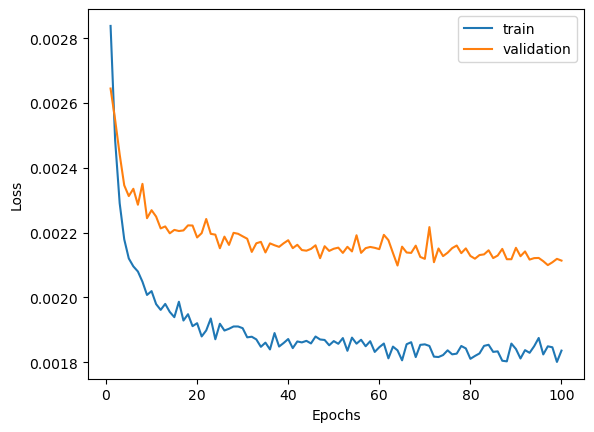

[Validation]:   0%|          | 0/200 [00:00<?, ?img/s]

============================== Measurements==============================
[avg_PSNR] 27.531838731765745
[avg_SSIM] 0.7125544485208257


In [ ]:
# Training & Validation
######################## WRITE YOUR ANSWER BELOW ########################
net = CascadeMRIReconstructionFramework(recon_net=CNN_Regularized(), n_cascade=5)
solver = lab.Solver(
    model=net,
    optimizer=torch.optim.Adam(net.parameters(), lr=0.0001),
    criterion=MSELoss(),
)
#########################################################################

# train & validate your network
epochs_to_train = 100
solver.train(epochs_to_train, train_loader, val_loader=val_loader)
solver.validate(test_loader)

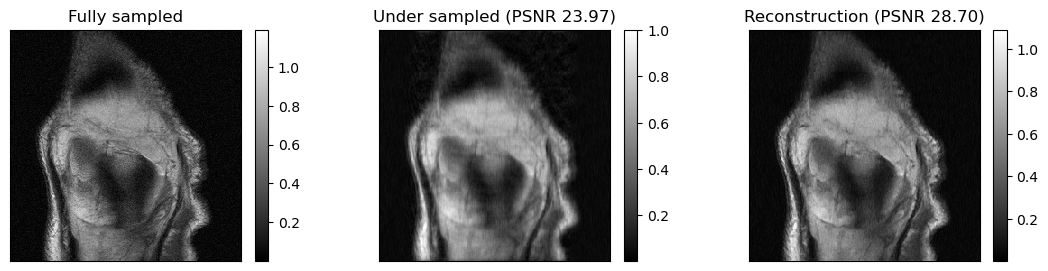

In [68]:
solver.visualize(test_loader, idx=100)